<a href="https://colab.research.google.com/github/mofuoku417/Univariate_Crude_Palm_Oil_Price_Prediction/blob/main/Crude_PalmOil_Price_Prediction_using_MLP_Regression_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


> **Predict Monthly Crude Palm Oil Price  with   Deep Learning (Multi-layer Perception Univariate Time series)**


> Project Objective:

> Design and Build an MLP in tensorflow to predict Monthly Crude Palm Oil Price


  * Data range: 1993 - 2022

  The dataset is a CSV format with:

  1. Monthly timestamp
  2. Monthly Crude Palm Oil Prices

'''


1. Project Overview and Import Libraries
2. Load and Inspect Monthly Crude Oil Price History
1. Data Preprocessing
2. Build the MLP model
1. Train the MLP
2. Plot Metrics and Evaluate the Model
2. Monthly Crude Palm Oil Prices
2. Visualize the predictions

'''

###Load the Required Libraries

In [42]:
!pip install scikeras
import math
import numpy as np # Python's fundamental package for scientific computing
import pandas as pd # For data analysis and manipulation
from datetime import date, timedelta # Date Operations
import matplotlib.pyplot as plt # To aid in visualizing
%matplotlib inline
import seaborn as sns
import matplotlib.dates as mdates # Date formatting
from sklearn.metrics import mean_absolute_error, mean_squared_error # To assess model performance error computation
from sklearn.preprocessing import MinMaxScaler # to standardize the crude palm oil price data
from tensorflow.keras.models import Sequential # Deep learning library, that is used in neural networks
#from tensorflow.keras.layers import LSTM, Dense # Deep learning classes for densely linked recurrent and regular layers
import tensorflow as tf
from keras.layers import Dropout
from keras.wrappers.scikit_learn import KerasRegressor
from scikeras.wrappers import KerasRegressor
from sklearn.neural_network import MLPRegressor
from tensorflow.keras.constraints import MaxNorm
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_log_error
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from keras.layers import Activation, Dense
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from pandas import read_csv
import seaborn as sns
sns.set_style('white', { 'axes.spines.right': False, 'axes.spines.top': False})
import random
random.seed(1) #Making this script reproducible

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# Establishing a timetable for data extraction
today = date.today()
end_date = today.strftime("%Y-%m")
start_date = '1993-03'

featurename = 'Price'

#Load dataset
path = 'https://raw.githubusercontent.com/mofuoku417/Univariate_Crude_Palm_Oil_Price_Prediction/main/Data/data.csv'
df = read_csv(path, parse_dates=True)

In [3]:
# Examining the dataset's structure
print(df.shape)
df.head(5)

(361, 3)


,Month,Price,Change
0,1993-03,408,-
1,1993-04,392,-3.92%
2,1993-05,371,-5.36%
3,1993-06,356,-4.04%
4,1993-07,362,1.69%


In [4]:
#Removing the change since it is not needed
del df['Change']
df.head(5)

,Month,Price
0,1993-03,408
1,1993-04,392
2,1993-05,371
3,1993-06,356
4,1993-07,362


In [5]:
#Checking data types
df.dtypes

Month    object
Price    object
dtype: object

In [6]:
#Renaming Price to cpo_pri (Crude palm oil price)
df.rename({'Price': 'cpo_pri', 'Month': 'date'}, axis=1, inplace=True)
df

,date,cpo_pri
0,1993-03,408
1,1993-04,392
2,1993-05,371
3,1993-06,356
4,1993-07,362
...,...,...
356,2022-11,945.74
357,2022-12,940.39
358,2023-01,941.97
359,2023-02,949.98


In [7]:
# converting column "Price" of the DataFrame to numeric
#df["cpo_pri"] = pd.to_numeric('cpo_pri', errors='coerce')

#df.dtypes

In [8]:
df.head(5)

,date,cpo_pri
0,1993-03,408
1,1993-04,392
2,1993-05,371
3,1993-06,356
4,1993-07,362


In [9]:
# Converting date column from object to date format
df['date'] = pd.to_datetime(df['date'].apply(lambda x: x.split()[0])) # Selecting only date
df.set_index('date',drop=True,inplace=True) # Setting date column as index
df.head()

,cpo_pri
date,
1993-03-01,408
1993-04-01,392
1993-05-01,371
1993-06-01,356
1993-07-01,362


In [10]:
df['cpo_pri'] = df['cpo_pri'].apply(lambda x: float(x.split()[0].replace(',', '')))
print(df.dtypes)

cpo_pri    float64
dtype: object


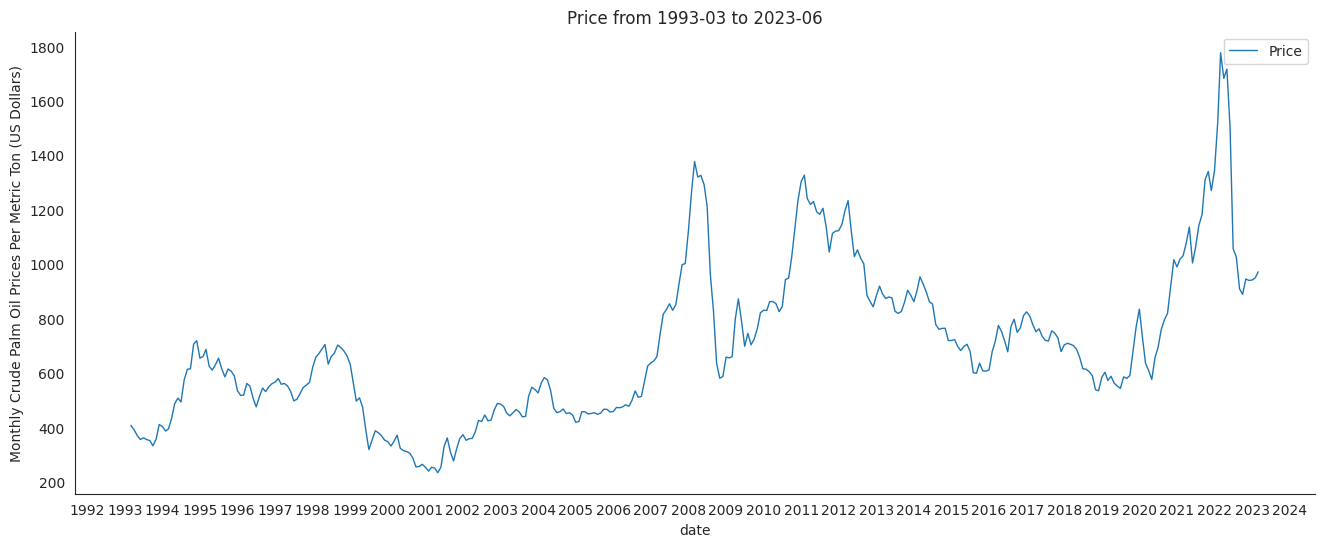

In [11]:
# Constructing the Time-Series Lineplot
years = mdates.YearLocator()
fig, ax1 = plt.subplots(figsize=(16, 6))
ax1.xaxis.set_major_locator(years)
ax1.legend([featurename], fontsize=12)
plt.title(featurename + ' from '+ start_date + ' to ' + end_date)
sns.lineplot(data=df['cpo_pri'], label=featurename, linewidth=1.0)
plt.ylabel('Monthly Crude Palm Oil Prices Per Metric Ton (US Dollars)')
plt.show()

### Checking for Duplicates

In [12]:
# Check number of duplicates while ignoring the index feature
n_duplicates = df.drop(labels=["cpo_pri"], axis=1).duplicated().sum()
print(f"You seem to have {n_duplicates} duplicates in your database.")

You seem to have 0 duplicates in your database.


###Checking for Missing values

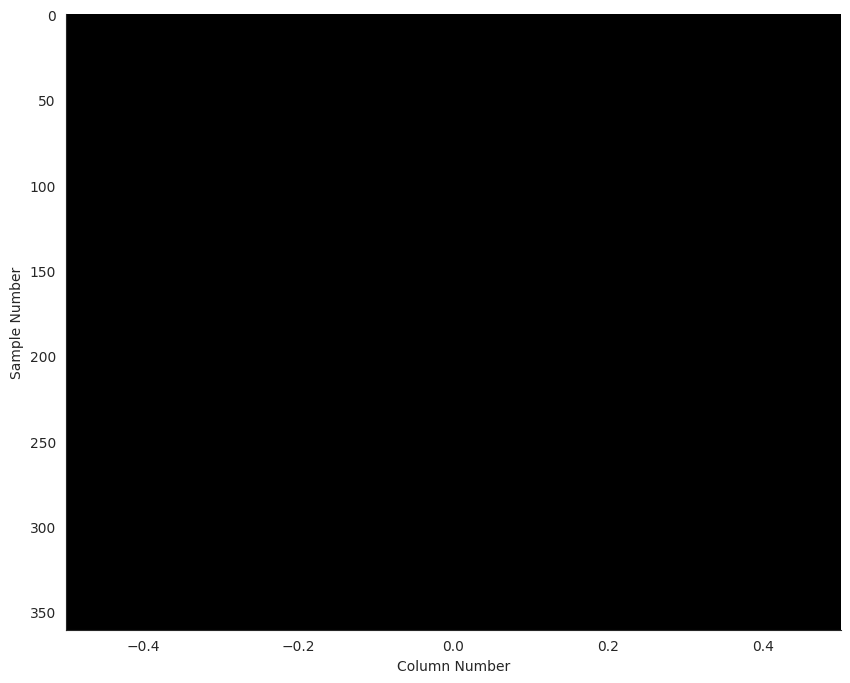

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
plt.imshow(df.isna(), aspect="auto", interpolation="nearest", cmap="gray")
plt.xlabel("Column Number")
plt.ylabel("Sample Number");

This figure shows that there are no missing data

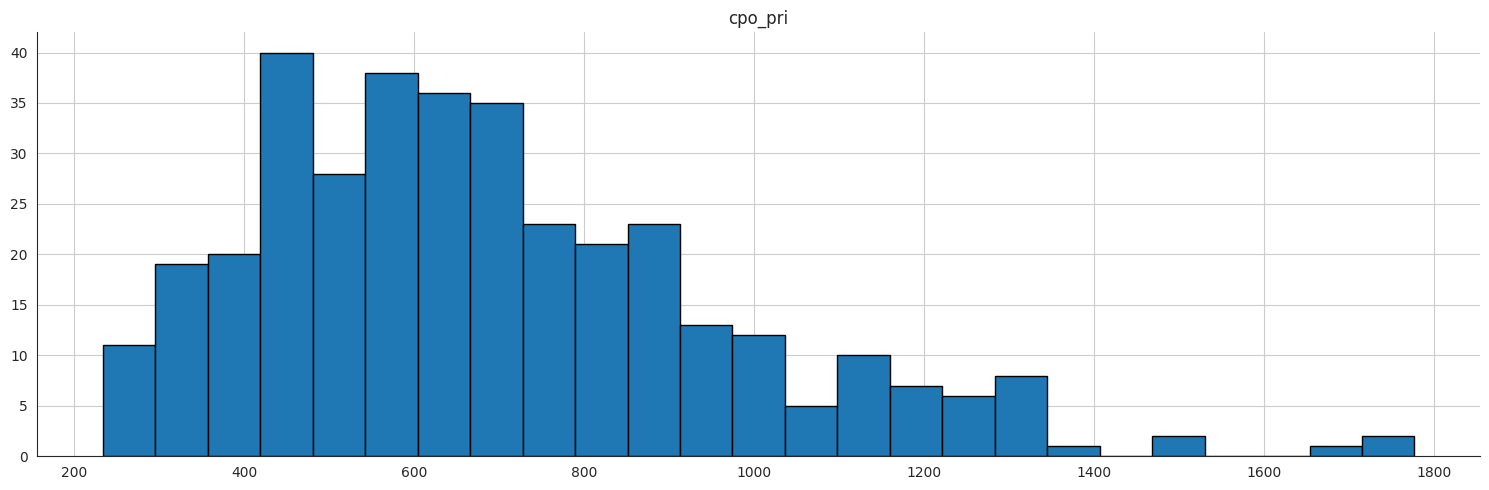

In [14]:
# Plots the histogram for each numerical feature in a separate subplot
df.hist(bins=25, figsize=(15, 5), edgecolor="black")
plt.tight_layout();

###Checking for Outliers

In [15]:
#Computing the percentage of Outliers
for k, v in df.items():
        q1 = v.quantile(0.25)
        q3 = v.quantile(0.75)
        irq = q3 - q1
        v_col = v[(v <= q1 - 1.5 * irq) | (v >= q3 + 1.5 * irq)]
        perc = np.shape(v_col)[0] * 100.0 / np.shape(df)[1]
        print("Column %s outliers = %.2f%%" % (k, perc))

Column cpo_pri outliers = 500.00%


<Figure size 1500x1500 with 0 Axes>

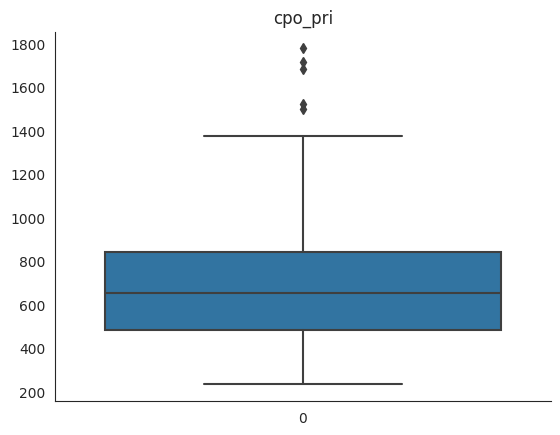

<Figure size 1500x1500 with 0 Axes>

In [16]:
#Ploting the boxplot of the Outliers
sns.boxplot(df['cpo_pri'])
plt.title('cpo_pri')
plt.figure(figsize=(15,15))

###Removing the Outliers

In [17]:
IQR=df.cpo_pri.quantile(0.75)-df.cpo_pri.quantile(0.25)
lower_bridge=df.cpo_pri.quantile(0.25)-(IQR*1.5)
upper_bridge=df.cpo_pri.quantile(0.75)+(IQR*1.5)
print(lower_bridge, upper_bridge)

-57.3449999999998 1385.495


In [18]:
df.loc[df['cpo_pri']>= 1385.495,'cpo_pri']= 1385.495
df.loc[df['cpo_pri']<= -57.3449999999998,'cpo_pri']= -57.3449999999998

###Ploting of Target variable without Outliers

<Figure size 1000x1000 with 0 Axes>

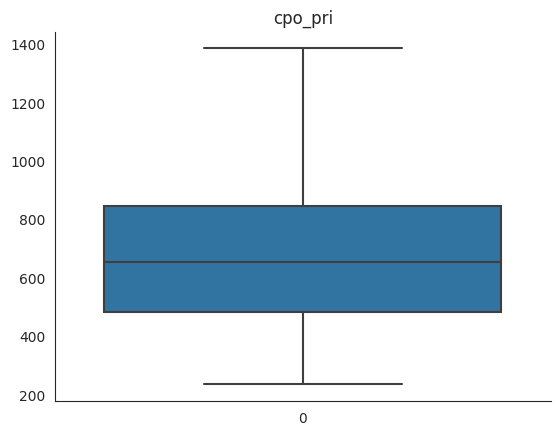

<Figure size 1000x1000 with 0 Axes>

In [19]:
sns.boxplot(df['cpo_pri'])
plt.title('cpo_pri')
plt.figure(figsize=(10,10))

In [20]:
# Target Selection
train_df = df.filter(['cpo_pri'])
data_unsc = train_df.values # data_unscaled data

# Compute the number of rows required to train the model on 80% of the data.
train_data_len = math.ceil(len(data_unsc) * 0.7)

# Scale the data
mmscaler = MinMaxScaler(feature_range=(0, 1))
np_data = mmscaler.fit_transform(data_unsc)

In [21]:
# Set the sequence len - the period for making a single forecast.
sequence_len = 40

# Index of Prediction
index_cpo_pri = train_df.columns.get_loc("cpo_pri")
print(index_cpo_pri)
# Divide the training data into train and train data sets.
# In the first stage, we determine the number of rows required to train the model on 80% of the data.
train_data_len = math.ceil(np_data.shape[0] * 0.8)

# create training and test set
train_data = np_data[0:train_data_len, :]
test_data = np_data[train_data_len - sequence_len:, :]

# The MLP model requires data in the following formats: [samples, time steps, features].
def partition_dataset(sequence_len, train_df):
    x, y = [], []
    data_len = train_df.shape[0]
    for i in range(sequence_len, data_len):
        x.append(train_df[i-sequence_len:i,:])
        y.append(train_df[i, index_cpo_pri])

    # Convert the x and y variables to numpy arrays.
    x = np.array(x)
    y = np.array(y)
    return x, y

# Create training and testing data.
X_train, y_train = partition_dataset(sequence_len, train_data)
X_test, y_test = partition_dataset(sequence_len, test_data)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

# Verify that the prediction value and the input value match
print(X_test[1][sequence_len-1][index_cpo_pri])
print(y_test[0])

0
(249, 40, 1) (249,)
(72, 40, 1) (72,)
0.44990208381278246
0.44990208381278246


In [22]:
 # The architecture of the MLP
cb = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
mlp_model = Sequential()
mlp_model.add(Dense(50, input_dim=sequence_len, activation='tanh'))
mlp_model.add(Dense(50, input_dim=sequence_len, activation='tanh'))
mlp_model.add(Dense(1))
# Compiling the model
mlp_model.compile(loss='mean_squared_error', optimizer='adam')
# Fitting to the training set
mlp_model.fit(X_train, y_train, epochs=200, batch_size=2, verbose=2)

Epoch 1/200
125/125 - 1s - loss: 0.0376 - 1s/epoch - 8ms/step
Epoch 2/200
125/125 - 0s - loss: 0.0075 - 163ms/epoch - 1ms/step
Epoch 3/200
125/125 - 0s - loss: 0.0057 - 170ms/epoch - 1ms/step
Epoch 4/200
125/125 - 0s - loss: 0.0048 - 163ms/epoch - 1ms/step
Epoch 5/200
125/125 - 0s - loss: 0.0038 - 174ms/epoch - 1ms/step
Epoch 6/200
125/125 - 0s - loss: 0.0032 - 170ms/epoch - 1ms/step
Epoch 7/200
125/125 - 0s - loss: 0.0042 - 177ms/epoch - 1ms/step
Epoch 8/200
125/125 - 0s - loss: 0.0043 - 262ms/epoch - 2ms/step
Epoch 9/200
125/125 - 0s - loss: 0.0032 - 396ms/epoch - 3ms/step
Epoch 10/200
125/125 - 0s - loss: 0.0038 - 303ms/epoch - 2ms/step
Epoch 11/200
125/125 - 0s - loss: 0.0028 - 291ms/epoch - 2ms/step
Epoch 12/200
125/125 - 0s - loss: 0.0043 - 206ms/epoch - 2ms/step
Epoch 13/200
125/125 - 0s - loss: 0.0034 - 157ms/epoch - 1ms/step
Epoch 14/200
125/125 - 0s - loss: 0.0043 - 160ms/epoch - 1ms/step
Epoch 15/200
125/125 - 0s - loss: 0.0032 - 163ms/epoch - 1ms/step
Epoch 16/200
125/125 -

In [23]:
history = mlp_model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=200,batch_size=2,verbose=1, callbacks=[cb])

Epoch 1/200
125/125 [==============================] - 0s 3ms/step - loss: 0.0014 - val_loss: 0.0034
Epoch 2/200
125/125 [==============================] - 0s 2ms/step - loss: 0.0010 - val_loss: 0.0029
Epoch 3/200
125/125 [==============================] - 0s 2ms/step - loss: 0.0015 - val_loss: 0.0032
Epoch 4/200
125/125 [==============================] - 0s 2ms/step - loss: 0.0014 - val_loss: 0.0052
Epoch 5/200
125/125 [==============================] - 0s 2ms/step - loss: 0.0010 - val_loss: 0.0029
Epoch 6/200
125/125 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 0.0036
Epoch 7/200
125/125 [==============================] - 0s 2ms/step - loss: 9.8719e-04 - val_loss: 0.0030
Epoch 8/200
125/125 [==============================] - 0s 2ms/step - loss: 9.8793e-04 - val_loss: 0.0030
Epoch 9/200
125/125 [==============================] - 0s 2ms/step - loss: 9.9676e-04 - val_loss: 0.0030
Epoch 10/200
125/125 [==============================] - 0s 2ms/step - loss: 0.0

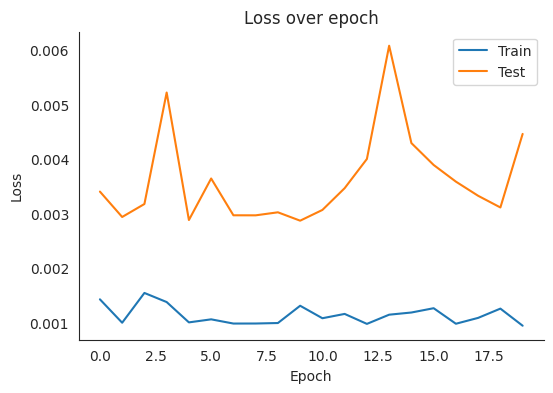

In [24]:
plt.figure(figsize=(6, 4))
plt.plot(history.history["loss"], label="Train")
plt.plot(history.history["val_loss"], label="Test")
plt.title("Loss over epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [25]:
# Obtain the predicted values
mlp_pred_scaled = mlp_model.predict(X_test)
mlp_pred = mmscaler.inverse_transform(mlp_pred_scaled)
y_test_unsc = mmscaler.inverse_transform(y_test.reshape(-1, 1))

3/3 [==============================] - 0s 3ms/step


In [26]:
# Mean Absolute Error (MAE)
mlp_MAE = mean_absolute_error(y_test_unsc, mlp_pred)
print(f'Median Absolute Error (MAE): {np.round(mlp_MAE, 2)}')

# Mean Absolute Percentage Error (MAPE)
mlp_MAPE = np.mean((np.abs(np.subtract(y_test_unsc, mlp_pred)/ y_test_unsc))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(mlp_MAPE, 2)} %')

# Root Mean Squared Error (RMSE)
mlp_RMSE = mean_squared_error(y_test_unsc, mlp_pred) ** 0.5
print(f'Root Mean Squared Error (RMSE): {np.round(mlp_RMSE, 2)} %')

# Mean Squared Error (MSE)
mlp_MSE = mean_squared_error(y_test_unsc, mlp_pred)
print('MSE value of the MLP Model:', mlp_MSE )

# r2_score
mlp_r2 = r2_score(y_test_unsc, mlp_pred)
print(f'R^2 Score: {np.round(mlp_r2, 2)} %')

Median Absolute Error (MAE): 47.35
Mean Absolute Percentage Error (MAPE): 5.76 %
Root Mean Squared Error (RMSE): 61.72 %
MSE value of the MLP Model: 3809.552385649791
R^2 Score: 0.94 %


In [27]:
train = pd.DataFrame(train_df[:train_data_len + 1]).rename(columns={'cpo_pri': 'X_train'})
train

,X_train
date,
1993-03-01,408.00
1993-04-01,392.00
1993-05-01,371.00
1993-06-01,356.00
1993-07-01,362.00
...,...
2016-12-01,811.38
2017-01-01,825.00
2017-02-01,808.61


<Axes: title={'center': 'MLP Predictions vs Actual'}, xlabel='date', ylabel='Price'>

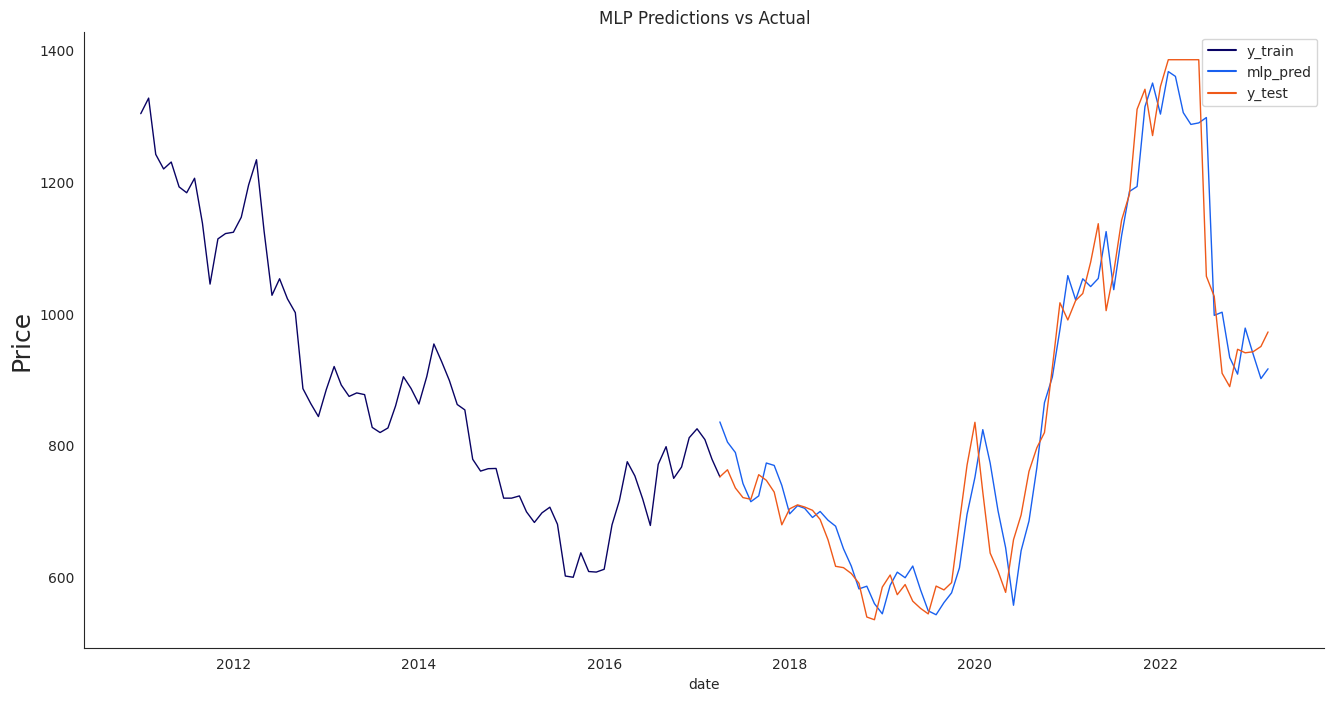

In [28]:
# The date starting from which the date is presented
display_start_date = "2010-12"

#
train = pd.DataFrame(train_df[:train_data_len + 1]).rename(columns={'cpo_pri': 'y_train'})
valid = pd.DataFrame(train_df[train_data_len:]).rename(columns={'cpo_pri': 'y_test'})
valid.insert(1, "mlp_pred", mlp_pred, True)
valid.insert(1, "residuals", valid["mlp_pred"] - valid["y_test"], True)
df_union = pd.concat([train, valid])

# Zoom in on a specific timeframe.
df_union_zoom = df_union[df_union.index > display_start_date]

# Create the lineplot
fig, ax1 = plt.subplots(figsize=(16, 8), sharex=True)
plt.title("MLP Predictions vs Actual")
sns.set_palette(["#090364", "#1960EF", "#EF5919"])
plt.ylabel(featurename, fontsize=18)
sns.lineplot(data=df_union_zoom[['y_train', 'mlp_pred', 'y_test']], linewidth=1.0, dashes=False, ax=ax1)

In [33]:
input_dim = sequence_len

###Performing Grid Search Operation

#### Tuning the Batch Size and Number of Epochs

In [34]:
from scikeras.wrappers import KerasRegressor
# Function to create model
def create_model():
 # create model
 model = Sequential()
 model.add(Dense(12, input_dim=input_dim, activation='relu'))
 model.add(Dense(1, activation='sigmoid'))
 # Compile model
 model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
 return model

# create model
model = KerasRegressor(model=create_model, verbose=0)
# define the grid search parameters
batch_size = [10, 20, 40, 60, 80, 100]
epochs = [10, 50, 100, 150, 200]
param_grid = dict(batch_size=batch_size, epochs=epochs)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X_train, y_train)

# summarize results
print("Best: %f using %s" % (grid.best_score_, grid.best_params_))
means = grid.cv_results_['mean_test_score']
stds = grid.cv_results_['std_test_score']
params = grid.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
# Best: 0.660034 using {'batch_size': 10, 'epochs': 100}

Best: 0.660034 using {'batch_size': 10, 'epochs': 100}
-3.806982 (2.711220) with: {'batch_size': 10, 'epochs': 10}
-0.371873 (0.758674) with: {'batch_size': 10, 'epochs': 50}
0.660034 (0.045309) with: {'batch_size': 10, 'epochs': 100}
-4.409683 (3.224397) with: {'batch_size': 20, 'epochs': 10}
-1.053588 (1.292450) with: {'batch_size': 20, 'epochs': 50}
-0.321181 (1.283072) with: {'batch_size': 20, 'epochs': 100}
-4.869103 (3.244922) with: {'batch_size': 40, 'epochs': 10}
-2.511198 (2.053349) with: {'batch_size': 40, 'epochs': 50}
-0.976495 (1.546245) with: {'batch_size': 40, 'epochs': 100}
-3.648768 (2.612212) with: {'batch_size': 60, 'epochs': 10}
-3.419965 (2.575887) with: {'batch_size': 60, 'epochs': 50}
-2.148212 (2.089329) with: {'batch_size': 60, 'epochs': 100}
-3.815472 (3.474393) with: {'batch_size': 80, 'epochs': 10}
-4.068971 (2.798028) with: {'batch_size': 80, 'epochs': 50}
-2.195263 (1.719028) with: {'batch_size': 80, 'epochs': 100}
-3.686759 (2.839154) with: {'batch_size':

In [ ]:
'''
# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_log_error

def create_model():

    model = Sequential(optimizer='rmsprop', neurons=16, learning_rate=0.001)
     # Adding the input layer and the first hidden layer
    model.add(Dense(12, input_dim=input_dim, activation='relu'))
    # Adding the output layer
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
    return(model)

batch_size = [10, 20]
epochs = [10, 100]
lr_values = [0.001, 0.01, 0.1, 0.2, 0.3]
optimizers = ['rmsprop', 'adam', 'SGD']
neuron_list = [16, 32, 64, 128, 256]

param_grid = dict(batch_size=batch_size, epochs=epochs, learning_rate=lr_values)

model1 = KerasRegressor(build_fn=create_model, verbose=0)
grid1 = GridSearchCV(estimator=model1, param_grid=param_grid, cv = 2, n_jobs=-1, verbose=1)
grid1.fit(X_train,y_train)

#optimizer=SGD(lr, momentum)
# optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']

print(" These are the results from Grid Search " )
print("\n The best estimator overall in the searched params:\n",grid1.best_estimator_)
print("\n The best score overall in the searched params:\n",grid1.best_score_)
print("\n The best parameters overall in the searched params:\n",grid1.best_params_)

train_pred = grid1.predict(X_train)
print('rmsle: ', np.sqrt(mean_squared_log_error(y_train, train_pred)))
print('rmse: ', np.sqrt(mean_squared_error(X_train, np.expm1(train_pred))))
print('mae: ', mean_absolute_error(train_data.cpo_pri, np.expm1(train_pred)))
# Reshaping X_train for efficient modelling
'''

'\n# Importing the Keras libraries and packages\nfrom keras.models import Sequential\nfrom keras.layers import Dense\nfrom keras.layers import LSTM\nfrom keras.layers import Dropout\nfrom keras.wrappers.scikit_learn import KerasRegressor\nfrom sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split\nfrom sklearn.metrics import mean_squared_log_error\n\ndef create_model():\n\n    model = Sequential(optimizer=\'rmsprop\', neurons=16, learning_rate=0.001)\n     # Adding the input layer and the first hidden layer\n    model.add(Dense(12, input_dim=input_dim, activation=\'relu\'))\n    # Adding the output layer\n    model.add(Dense(1, activation=\'sigmoid\'))\n    model.compile(loss=\'mse\', optimizer=\'adam\', metrics=[\'accuracy\'])\n    return(model)\n\nbatch_size = [10, 20]\nepochs = [10, 100]\nlr_values = [0.001, 0.01, 0.1, 0.2, 0.3]\noptimizers = [\'rmsprop\', \'adam\', \'SGD\']\nneuron_list = [16, 32, 64, 128, 256]\n\nparam_grid = dict(batch_size=batch_size,

#### Grid searching for Network Weight Initialization

In [35]:
# Function to create the MLP model.
def create_model(init_mode='uniform'):
 model = Sequential()
 model.add(Dense(12, input_dim = input_dim, kernel_initializer=init_mode, activation='relu'))
 model.add(Dense(1, kernel_initializer=init_mode, activation='sigmoid'))
 # Compile model
 model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
 return model

# create model
model = KerasRegressor(model=create_model, epochs=100, batch_size=10, verbose=0)
# define the grid search parameters
init_mode = ['uniform', 'lecun_uniform', 'normal', 'zero', 'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform']
param_grid = dict(model__init_mode=init_mode)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

# summarize results
print("Best: %f using %s" % (grid.best_score_, grid.best_params_))
means = grid.cv_results_['mean_test_score']
stds = grid.cv_results_['std_test_score']
params = grid.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
# Best: 0.880143 using {'model__init_mode': 'glorot_normal'}

Best: 0.714379 using {'model__init_mode': 'glorot_normal'}
0.367289 (0.440376) with: {'model__init_mode': 'uniform'}
0.514104 (0.336416) with: {'model__init_mode': 'lecun_uniform'}
0.310830 (0.475963) with: {'model__init_mode': 'normal'}
-2.960894 (2.471735) with: {'model__init_mode': 'zero'}
0.714379 (0.044029) with: {'model__init_mode': 'glorot_normal'}
0.600100 (0.076231) with: {'model__init_mode': 'glorot_uniform'}
0.609390 (0.213475) with: {'model__init_mode': 'he_normal'}
0.691139 (0.240219) with: {'model__init_mode': 'he_uniform'}
Best: 0.714379 using {'model__init_mode': 'glorot_normal'}
0.367289 (0.440376) with: {'model__init_mode': 'uniform'}
0.514104 (0.336416) with: {'model__init_mode': 'lecun_uniform'}
0.310830 (0.475963) with: {'model__init_mode': 'normal'}
-2.960894 (2.471735) with: {'model__init_mode': 'zero'}
0.714379 (0.044029) with: {'model__init_mode': 'glorot_normal'}
0.600100 (0.076231) with: {'model__init_mode': 'glorot_uniform'}
0.609390 (0.213475) with: {'model

#### Grid Searching for Neuron Activation Function

In [36]:
def create_model(activation='relu'):
 # create model
 model = Sequential()
 model.add(Dense(12, input_dim = input_dim, kernel_initializer='uniform', activation=activation))
 model.add(Dense(1, kernel_initializer='uniform', activation='sigmoid'))
 # Compile model
 model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
 return model
# fix random seed for reproducibility
seed = 7
tf.random.set_seed(seed)

# create model
model = KerasRegressor(model=create_model, epochs=100, batch_size=10, verbose=0)
# define the grid search parameters
activation = ['softmax', 'softplus', 'softsign', 'relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear']
param_grid = dict(model__activation=activation)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

# summarize results
print("Best: %f using %s" % (grid.best_score_, grid.best_params_))
means = grid.cv_results_['mean_test_score']
stds = grid.cv_results_['std_test_score']
params = grid.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

# Best: 0.811305 using {'model__activation': 'linear'}

Best: 0.811305 using {'model__activation': 'linear'}
-0.120665 (0.610461) with: {'model__activation': 'softmax'}
0.423754 (0.369238) with: {'model__activation': 'softplus'}
0.732765 (0.052409) with: {'model__activation': 'softsign'}
0.717310 (0.095503) with: {'model__activation': 'relu'}
0.766791 (0.040225) with: {'model__activation': 'tanh'}
0.376513 (0.404642) with: {'model__activation': 'sigmoid'}
0.396346 (0.272018) with: {'model__activation': 'hard_sigmoid'}
0.811305 (0.033547) with: {'model__activation': 'linear'}
Best: 0.811305 using {'model__activation': 'linear'}
-0.120665 (0.610461) with: {'model__activation': 'softmax'}
0.423754 (0.369238) with: {'model__activation': 'softplus'}
0.732765 (0.052409) with: {'model__activation': 'softsign'}
0.717310 (0.095503) with: {'model__activation': 'relu'}
0.766791 (0.040225) with: {'model__activation': 'tanh'}
0.376513 (0.404642) with: {'model__activation': 'sigmoid'}
0.396346 (0.272018) with: {'model__activation': 'hard_sigmoid'}
0.8113

#### Grid Searching Learning Rate and Momentum

In [37]:
def create_model():
 # create model
 model = Sequential()
 model.add(Dense(12, input_dim=input_dim, activation='relu'))
 model.add(Dense(1, activation='sigmoid'))
 return model

model = KerasRegressor(model=create_model, loss="mse", optimizer="SGD", epochs=100, batch_size=10, verbose=0)
# define the grid search parameters
learn_rate = [0.001, 0.01, 0.1, 0.2, 0.3]
momentum = [0.0, 0.2, 0.4, 0.6, 0.8, 0.9]
param_grid = dict(optimizer__learning_rate=learn_rate, optimizer__momentum=momentum)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X_train, y_train)

# summarize results
print("Best: %f using %s" % (grid.best_score_, grid.best_params_))
means = grid.cv_results_['mean_test_score']
stds = grid.cv_results_['std_test_score']
params = grid.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
# Best: 0.831320 using {'optimizer__learning_rate': 0.3, 'optimizer__momentum': 0.2}

Best: 0.831320 using {'optimizer__learning_rate': 0.3, 'optimizer__momentum': 0.2}
-2.937693 (2.901382) with: {'optimizer__learning_rate': 0.001, 'optimizer__momentum': 0.0}
-3.058722 (2.911165) with: {'optimizer__learning_rate': 0.001, 'optimizer__momentum': 0.2}
-3.097848 (3.189768) with: {'optimizer__learning_rate': 0.001, 'optimizer__momentum': 0.4}
-2.798180 (2.768077) with: {'optimizer__learning_rate': 0.001, 'optimizer__momentum': 0.6}
-2.123294 (1.722098) with: {'optimizer__learning_rate': 0.001, 'optimizer__momentum': 0.8}
-2.303982 (1.932376) with: {'optimizer__learning_rate': 0.001, 'optimizer__momentum': 0.9}
-2.088894 (1.801603) with: {'optimizer__learning_rate': 0.01, 'optimizer__momentum': 0.0}
-1.219125 (1.252403) with: {'optimizer__learning_rate': 0.01, 'optimizer__momentum': 0.2}
-1.978263 (1.771028) with: {'optimizer__learning_rate': 0.01, 'optimizer__momentum': 0.4}
-0.612661 (0.965314) with: {'optimizer__learning_rate': 0.01, 'optimizer__momentum': 0.6}
0.428185 (0

#### Grid Searching the Number of Neurons in the Hidden Layer

In [43]:
def create_model(neurons):
 # create model
 model = Sequential()
 model.add(Dense(neurons, input_dim = input_dim, kernel_initializer='uniform', activation='linear', kernel_constraint=MaxNorm(4)))
 model.add(Dropout(0.2))
 model.add(Dense(1, kernel_initializer='uniform', activation='sigmoid'))
 # Compile model
 model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
 return model

# create model
model = KerasRegressor(model=create_model, epochs=100, batch_size=10, verbose=0)
# define the grid search parameters
neurons = [1, 5, 10, 15, 20, 25, 30]
param_grid = dict(model__neurons=neurons)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
# Best: 0.831356 using {'model__neurons': 30}

Best: 0.831356 using {'model__neurons': 30}
-0.598759 (1.044286) with: {'model__neurons': 1}
0.628020 (0.113167) with: {'model__neurons': 5}
0.785020 (0.015288) with: {'model__neurons': 10}
0.815602 (0.040162) with: {'model__neurons': 15}
0.816506 (0.042609) with: {'model__neurons': 20}
0.826775 (0.033953) with: {'model__neurons': 25}
0.831356 (0.039824) with: {'model__neurons': 30}


#### Grid Searching the Dropout Regularization

In [44]:
def create_model(dropout_rate, weight_constraint):
 model = Sequential()
 model.add(Dense(12, input_dim=input_dim, kernel_initializer='uniform', activation='linear', kernel_constraint=MaxNorm(weight_constraint)))
 model.add(Dropout(dropout_rate))
 model.add(Dense(1, kernel_initializer='uniform', activation='sigmoid'))
 # Compile model
 model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
 return model

# create model
model = KerasRegressor(model=create_model, epochs=100, batch_size=10, verbose=0)
# define the grid search parameters
weight_constraint = [1.0, 2.0, 3.0, 4.0, 5.0]
dropout_rate = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
param_grid = dict(model__dropout_rate=dropout_rate, model__weight_constraint=weight_constraint)
#param_grid = dict(model__dropout_rate=dropout_rate)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X_train, y_train)

# summarize results
print("Best: %f using %s" % (grid.best_score_, grid.best_params_))
means = grid.cv_results_['mean_test_score']
stds = grid.cv_results_['std_test_score']
params = grid.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
# Best: 0.874012 using {'model__dropout_rate': 0.0, 'model__weight_constraint': 2.0}

Best: 0.813301 using {'model__dropout_rate': 0.1, 'model__weight_constraint': 1.0}
0.800939 (0.022703) with: {'model__dropout_rate': 0.0, 'model__weight_constraint': 1.0}
0.809476 (0.044893) with: {'model__dropout_rate': 0.0, 'model__weight_constraint': 2.0}
0.801371 (0.015572) with: {'model__dropout_rate': 0.0, 'model__weight_constraint': 3.0}
0.806582 (0.012858) with: {'model__dropout_rate': 0.0, 'model__weight_constraint': 4.0}
0.805014 (0.042733) with: {'model__dropout_rate': 0.0, 'model__weight_constraint': 5.0}
0.813301 (0.036879) with: {'model__dropout_rate': 0.1, 'model__weight_constraint': 1.0}
0.795358 (0.047911) with: {'model__dropout_rate': 0.1, 'model__weight_constraint': 2.0}
0.803838 (0.028893) with: {'model__dropout_rate': 0.1, 'model__weight_constraint': 3.0}
0.802709 (0.050642) with: {'model__dropout_rate': 0.1, 'model__weight_constraint': 4.0}
0.796650 (0.059810) with: {'model__dropout_rate': 0.1, 'model__weight_constraint': 5.0}
0.808421 (0.023590) with: {'model__dr

#### Grid searching for Training Optimization

In [ ]:
#import time
#%time
def create_model():
 model = Sequential()
 model.add(Dense(12, input_dim=input_dim, activation='relu'))
 model.add(Dense(1, activation='sigmoid'))
 return model

# create model
model = KerasRegressor(model=create_model, loss="mse", epochs=100, batch_size=10, verbose=0)
# define the grid search parameters
optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
param_grid = dict(optimizer=optimizer)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
# Best: 0.864805 using {'optimizer': 'Nadam'}

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 13.1 µs
Best: 0.864805 using {'optimizer': 'Nadam'}
-1.024778 (0.843313) with: {'optimizer': 'SGD'}
0.846145 (0.030875) with: {'optimizer': 'RMSprop'}
-2.576708 (1.549857) with: {'optimizer': 'Adagrad'}
-1.953666 (2.327512) with: {'optimizer': 'Adadelta'}
0.855693 (0.047866) with: {'optimizer': 'Adam'}
-0.198660 (1.066232) with: {'optimizer': 'Adamax'}
0.864805 (0.039096) with: {'optimizer': 'Nadam'}


In [ ]:
'''
def create_model(optimizer = 'rmsprop', units = 16, learning_rate = 0.001):
    ann = Sequential() # Initialising ANN
    ann.add(tf.keras.layers.Dense(units = units, activation = "relu")) # Adding First Hidden Layer
    ann.add(tf.keras.layers.Dense(units = units, activation = "relu")) # Adding Second Hidden Layer
    ann.add(tf.keras.layers.Dense(units = units, activation = "relu")) # Adding Third Hidden Layer
    ann.add(tf.keras.layers.Dense(units = 1)) # Adding Output Layer
    ann.compile(optimizer = optimizer, loss = 'mean_absolute_error') # Compiling ANN
    return ann

ann = KerasRegressor(model = create_model,
                     verbose = 0,
                     learning_rate = 0.001,
                     units = 16
                     )

optimizers = ['rmsprop', 'adam', 'SGD']
epoch_values = [10, 25, 50, 100, 150, 200]
batches = [10, 20, 30, 40, 50, 100, 1000]
units = [16, 32, 64, 128, 256]
lr_values = [0.001, 0.01, 0.1, 0.2, 0.3]

hyperparameters = dict(optimizer = optimizers,
                        epochs = epoch_values,
                        batch_size = batches,
                        units = units,
                        learning_rate = lr_values
                        )

grid = GridSearchCV(estimator = ann, cv = 5, param_grid = hyperparameters)

history = grid.fit(X_train,
                   Y_train,
                   batch_size = 32,
                   validation_data = (X_test, Y_test),
                   epochs = 100
                   ) # Fitting ANN
'''